In [1]:
# Standard
import pandas as pd
import numpy as np
import os
# Pycaret
from pycaret.classification import *
# Plots
from plotly.offline import iplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
# Sklearn tools
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
# Extras
from datetime import date
import warnings
warnings.filterwarnings("ignore")
# Datapath and Setup
os.chdir("..")
PATH = os.getcwd()+os.sep
RANDOM_SEED = 142
K_FOLDS = 5

In [2]:
# Helper functions for structured data
# Get info about the dataset
def dataset_info(dataset, dataset_name: str):
    print(f"Dataset Name: {dataset_name} \
        | Number of Samples: {dataset.shape[0]} \
        | Number of Columns: {dataset.shape[1]}")
    print(30*"=")
    print("Column             Data Type")
    print(dataset.dtypes)
    print(30*"=")
    missing_data = dataset.isnull().sum()
    if sum(missing_data) > 0:
        print(missing_data[missing_data.values > 0])
    else:
        print("No Missing Data on this Dataset!")
    print(30*"=")
    print("Memory Usage: {} MB".\
         format(np.round(
         dataset.memory_usage(index=True).sum() / 10e5, 3
         )))
# Dataset Sampling
def data_sampling(dataset, frac: float, random_seed: int):
    data_sampled_a = dataset.sample(frac=frac, random_state=random_seed)
    data_sampled_b =  dataset.drop(data_sampled_a.index).reset_index(drop=True)
    data_sampled_a.reset_index(drop=True, inplace=True)
    return data_sampled_a, data_sampled_b   
# Bar Plot
def bar_plot(data, plot_title: str, x_axis: str, y_axis: str):
    colors = ["#0080ff",] * len(data)
    colors[0] = "#ff8000"
    trace = go.Bar(y=data.values, x=data.index, text=data.values, 
                    marker_color=colors)
    layout = go.Layout(autosize=False, height=600,
                    title={"text" : plot_title,
                       "y" : 0.9,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"},  
                    xaxis={"title" : x_axis},
                    yaxis={"title" : y_axis},)
    fig = go.Figure(data=trace, layout=layout)
    fig.update_layout(template="simple_white")
    fig.update_traces(textposition="outside",
                    textfont_size=14,
                    marker=dict(line=dict(color="#000000", width=2)))                
    fig.update_yaxes(automargin=True)
    iplot(fig)
# Plot Pie Chart
def pie_plot(data, plot_title: str):
    trace = go.Pie(labels=data.index, values=data.values)
    layout = go.Layout(autosize=False,
                    title={"text" : plot_title,
                       "y" : 0.9,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"})
    fig = go.Figure(data=trace, layout=layout)
    fig.update_traces(textfont_size=14,
                    marker=dict(line=dict(color="#000000", width=2)))
    fig.update_yaxes(automargin=True)            
    iplot(fig)
# Histogram
def histogram_plot(data, plot_title: str, y_axis: str):
    trace = go.Histogram(x=data)
    layout = go.Layout(autosize=False,
                    title={"text" : plot_title,
                       "y" : 0.9,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"},  
                    yaxis={"title" : y_axis})
    fig = go.Figure(data=trace, layout=layout)
    fig.update_traces(marker=dict(line=dict(color="#000000", width=2)))
    fig.update_layout(template="simple_white")
    fig.update_yaxes(automargin=True)
    iplot(fig)
# Particular case: Histogram subplot (1, 2)
def histogram_subplot(dataset_a, dataset_b, feature_a: str,
                        feature_b: str, title: str, title_a: str, title_b: str):
    fig = make_subplots(rows=1, cols=2, subplot_titles=(
                        title_a,
                        title_b
                        )
                    )
    fig.add_trace(go.Histogram(x=dataset_a[feature_a],
                               showlegend=False),
                                row=1, col=1)
    fig.add_trace(go.Histogram(x=dataset_b[feature_b],
                               showlegend=False),
                              row=1, col=2)
    fig.update_layout(template="simple_white")
    fig.update_layout(autosize=False,
                        title={"text" : title,
                        "y" : 0.9,
                        "x" : 0.5,
                        "xanchor" : "center",
                        "yanchor" : "top"},  
                        yaxis={"title" : "<i>Frequency</i>"})
    fig.update_traces(marker=dict(line=dict(color="#000000", width=2)))
    fig.update_yaxes(automargin=True)
    iplot(fig)
# Calculate scores with Test/Unseen labeled data
def test_score_report(data_unseen, predict_unseen):
    le = LabelEncoder()
    data_unseen["Label"] = le.fit_transform(data_unseen.Churn.values)
    data_unseen["Label"] = data_unseen["Label"].astype(int)
    accuracy = accuracy_score(data_unseen["Label"], predict_unseen["Label"])
    roc_auc = roc_auc_score(data_unseen["Label"], predict_unseen["Label"])
    precision = precision_score(data_unseen["Label"], predict_unseen["Label"])
    recall = recall_score(data_unseen["Label"], predict_unseen["Label"])
    f1 = f1_score(data_unseen["Label"], predict_unseen["Label"])

    df_unseen = pd.DataFrame({
        "Accuracy" : [accuracy],
        "AUC" : [roc_auc],
        "Recall" : [recall],
        "Precision" : [precision],
        "F1 Score" : [f1]
    })
    return df_unseen
# Confusion Matrix
def conf_mat(data_unseen, predict_unseen):
    unique_label = data_unseen["Label"].unique()
    cmtx = pd.DataFrame(
        confusion_matrix(data_unseen["Label"],
                         predict_unseen["Label"],
                         labels=unique_label), 
        index=['{:}'.format(x) for x in unique_label], 
        columns=['{:}'.format(x) for x in unique_label]
    )
    ax = sns.heatmap(cmtx, annot=True, fmt="d", cmap="YlGnBu")
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Target');
    ax.set_title("Predict Unseen Confusion Matrix", size=14);

In [5]:
import os
os.chdir("/Users/meenakshi")   # move into your home directory
print("CWD:", os.getcwd())



CWD: /Users/meenakshi


In [7]:
import pandas as pd
dataset = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
dataset.head(3)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [8]:
dataset[dataset.duplicated()]


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [9]:
dataset_info(dataset, "customers")

Dataset Name: customers         | Number of Samples: 7043         | Number of Columns: 21
Column             Data Type
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
No Missing Data on this Dataset!
Memory Usage: 1.183 MB


In [10]:
dataset["TotalCharges"] = pd.to_numeric(dataset["TotalCharges"], errors="coerce")
print(f"The Feature TotalCharges is type {dataset.TotalCharges.dtype} now!")

The Feature TotalCharges is type float64 now!


In [11]:
pie_plot(dataset["Churn"].value_counts(), 
         plot_title="<b>Client Churn Distribution<b>")

In [12]:
df_aux = dataset.query('Churn == "No"')
df_aux = df_aux["Contract"].value_counts()
bar_plot(df_aux, "<b>Contract Types of not Churned Clients</b>",
         "<i>Contract</i>", "<i>Count</i>")

In [13]:
df_aux = dataset.query('Churn == "Yes"')
df_aux = df_aux["Contract"].value_counts()
bar_plot(df_aux, "<b>Contract Types of Churned Clients</b>",
         "<i>Contract</i>", "<i>Count</i>")


In [14]:
df_aux = dataset.query('(Contract == "Month-to-month") and (Churn == "No")')
histogram_subplot(df_aux, df_aux, "MonthlyCharges", "TotalCharges", 
                  "<b>Charges Distribution for Month-to-month contracts for not Churned Clients</b>",
                  "(a) Monthtly Charges Distribution", "(b) Total Charges Distribution")

In [15]:
df_aux = dataset.query('(Contract == "Month-to-month") and (Churn == "Yes")')
histogram_subplot(df_aux, df_aux, "MonthlyCharges", "TotalCharges", 
                  "<b>Charges Distribution for Month-to-month contracts for Churned Clients</b>",
                  "(a) Monthtly Charges Distribution", "(b) Total Charges Distribution")


In [16]:
df_aux = dataset.query(('Contract == Month-to-month') and ('Churn == "Yes"'))
df_aux = df_aux["PaymentMethod"].value_counts()
bar_plot(df_aux, "<b>Payment Method of Month-to-month contract Churned Clients</b>",
         "<i>Payment Method</i>", "<i>Count</i>")

In [17]:
df_aux = dataset.query(('Contract == Month-to-month') and ('Churn == "Yes"'))
df_aux = df_aux["tenure"].value_counts().head(5)
bar_plot(df_aux, "<b>Tenure of Month-to-month contract for Churned Clients</b>",
         "<i>Tenure</i>", "<i>Count</i>")

In [18]:
data, data_unseen = data_sampling(dataset, 0.9, RANDOM_SEED)
print(f"There are {data_unseen.shape[0]} samples for Unseen Data.")

There are 704 samples for Unseen Data.


In [19]:
from pycaret.classification import setup

exp01 = setup(data=data, target="Churn")


,Description,Value
0,Session id,2989
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(6339, 21)"
5,Transformed data shape,"(6339, 42)"
6,Transformed train set shape,"(4437, 42)"
7,Transformed test set shape,"(1902, 42)"
8,Numeric features,4
9,Categorical features,16


In [20]:
from pycaret.classification import compare_models, pull

best_model = compare_models()   # trains and compares many models
results = pull()                # get leaderboard as a DataFrame
results.head()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7710,0.7392,0.7710,0.7572,0.7597,0.3676,0.3746,0.1470
lr,Logistic Regression,0.7451,0.8272,0.7451,0.7504,0.6571,0.0892,0.1756,0.2760
dt,Decision Tree Classifier,0.7316,0.5000,0.7316,0.5352,0.6182,0.0000,0.0000,0.0290
ridge,Ridge Classifier,0.7316,0.8360,0.7316,0.5352,0.6182,0.0000,0.0000,0.0280
rf,Random Forest Classifier,0.7316,0.7729,0.7316,0.5352,0.6182,0.0000,0.0000,0.0520
qda,Quadratic Discriminant Analysis,0.7316,0.4913,0.7316,0.5352,0.6182,0.0000,0.0000,0.0260
ada,Ada Boost Classifier,0.7316,0.5000,0.7316,0.5352,0.6182,0.0000,0.0000,0.0230
gbc,Gradient Boosting Classifier,0.7316,0.5000,0.7316,0.5352,0.6182,0.0000,0.0000,0.0500
lda,Linear Discriminant Analysis,0.7316,0.5000,0.7316,0.5352,0.6182,0.0000,0.0000,0.0280
et,Extra Trees Classifier,0.7316,0.7037,0.7316,0.5352,0.6182,0.0000,0.0000,0.0450


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7710,0.7392,0.7710,0.7572,0.7597,0.3676,0.3746,0.147
lr,Logistic Regression,0.7451,0.8272,0.7451,0.7504,0.6571,0.0892,0.1756,0.276
dt,Decision Tree Classifier,0.7316,0.5000,0.7316,0.5352,0.6182,0.0000,0.0000,0.029
ridge,Ridge Classifier,0.7316,0.8360,0.7316,0.5352,0.6182,0.0000,0.0000,0.028
rf,Random Forest Classifier,0.7316,0.7729,0.7316,0.5352,0.6182,0.0000,0.0000,0.052


In [21]:
from pathlib import Path
import pandas as pd
from pycaret.classification import *

csv_name = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

csv_path = Path.cwd() / csv_name
if not csv_path.exists():
    csv_path = Path.home() / "Downloads" / csv_name

data = pd.read_csv(csv_path)
print("Loaded from:", csv_path)

data.head(3)


Loaded from: /Users/meenakshi/WA_Fn-UseC_-Telco-Customer-Churn.csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [22]:
RANDOM_SEED = 7507

exp01 = setup(
    data=data,
    target="Churn",
    session_id=RANDOM_SEED,
    log_experiment=False,   # no mlflow
    n_jobs=1                # ✅ no parallel workers → no BrokenProcessPool
)


,Description,Value
0,Session id,7507
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(7043, 21)"
5,Transformed data shape,"(7043, 42)"
6,Transformed train set shape,"(4930, 42)"
7,Transformed test set shape,"(2113, 42)"
8,Numeric features,3
9,Categorical features,17


In [23]:
lr = create_model('lr', cross_validation=False)   # Logistic Regression
lr


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.7549,0.8274,0.7549,0.7848,0.6720,0.1186,0.2306


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7507, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
evaluate_model(lr)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [25]:
exp01 = setup(
    data=data,
    target="Churn",
    session_id=RANDOM_SEED,
    ignore_features=["customerID"],
    numeric_features=["SeniorCitizen"],
    normalize=True,
    transformation=True,
    feature_selection=True,
    remove_outliers=True,
    remove_multicollinearity=True,
    fix_imbalance=True,
    pca=True,
    bin_numeric_features=["MonthlyCharges", "TotalCharges"],
    experiment_name="customer-churn-prediction",
    log_experiment=False,
    n_jobs=1
)


,Description,Value
0,Session id,7507
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(7043, 21)"
5,Transformed data shape,"(8969, 4)"
6,Transformed train set shape,"(6856, 4)"
7,Transformed test set shape,"(2113, 4)"
8,Ignore features,1
9,Numeric features,1


In [26]:
lr = create_model('lr', cross_validation=False)
evaluate_model(lr)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.6001,0.5886,0.6001,0.6629,0.6208,0.1229,0.1292


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [27]:
top_model = compare_models(
    fold=K_FOLDS,
    sort="F1",
    n_select=1,
    exclude=["gbc", "catboost"]   # ← instead of blacklist=
)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.6744,0.6027,0.6744,0.6510,0.6606,0.1022,0.1035,0.6740
qda,Quadratic Discriminant Analysis,0.6371,0.5923,0.6371,0.6590,0.6464,0.1235,0.1244,0.6840
knn,K Neighbors Classifier,0.6335,0.5803,0.6335,0.6596,0.6441,0.1238,0.1253,0.6960
lightgbm,Light Gradient Boosting Machine,0.6314,0.5434,0.6314,0.6516,0.6396,0.1041,0.1052,0.7280
et,Extra Trees Classifier,0.6268,0.5582,0.6268,0.6519,0.6367,0.1047,0.1058,0.8080
xgboost,Extreme Gradient Boosting,0.6286,0.5424,0.6286,0.6428,0.6344,0.0822,0.0829,0.7300
ridge,Ridge Classifier,0.6168,0.5938,0.6168,0.6634,0.6336,0.1281,0.1323,0.6940
lda,Linear Discriminant Analysis,0.6168,0.5937,0.6168,0.6634,0.6336,0.1281,0.1323,0.6820
svm,SVM - Linear Kernel,0.6154,0.5778,0.6154,0.6561,0.6299,0.1120,0.1148,0.6900
ada,Ada Boost Classifier,0.6207,0.5376,0.6207,0.6424,0.6299,0.0811,0.0820,0.7920


In [28]:
tuned_model = tune_model(estimator=top_model, fold=K_FOLDS,
                         optimize="F1", choose_better=True,
                         verbose=False)

[LightGBM] [Info] Number of positive: 2734, number of negative: 2734
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 5468, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2755, number of negative: 2755
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 5510, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2739, number of negative: 2739
[LightGBM] [Info] Auto-choosing col-wise multi-threading, t

In [29]:
plot_model(tuned_model, plot="parameter")

,Parameters
priors,None
var_smoothing,1


In [30]:
bagged_model = ensemble_model(tuned_model, fold=K_FOLDS)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7191,0.8230,0.7191,0.8023,0.7352,0.4148,0.4524
1,0.6947,0.8154,0.6947,0.7930,0.7125,0.3788,0.4218
2,0.7130,0.8114,0.7130,0.7863,0.7291,0.3912,0.4207
3,0.7363,0.8320,0.7363,0.8128,0.7514,0.4440,0.4801
4,0.7231,0.8082,0.7231,0.7909,0.7385,0.4060,0.4335
Mean,0.7172,0.8180,0.7172,0.7971,0.7333,0.4070,0.4417
Std,0.0136,0.0086,0.0136,0.0094,0.0127,0.0222,0.0223


In [31]:
boosted_model = ensemble_model(tuned_model, fold=K_FOLDS,
                               method="Boosting")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7008,0.7728,0.7008,0.7516,0.7155,0.3346,0.3487
1,0.7191,0.7729,0.7191,0.7536,0.7304,0.3519,0.3602
2,0.6968,0.7519,0.6968,0.7432,0.7110,0.3184,0.3299
3,0.7221,0.7725,0.7221,0.7554,0.7332,0.3557,0.3635
4,0.6927,0.7395,0.6927,0.7432,0.7078,0.3140,0.3270
Mean,0.7063,0.7619,0.7063,0.7494,0.7196,0.3349,0.3459
Std,0.0120,0.0138,0.0120,0.0052,0.0103,0.0169,0.0151


In [32]:
blended_model = blend_models(estimator_list=[tuned_model, boosted_model],
                            fold=K_FOLDS)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7211,0.8169,0.7211,0.8008,0.7370,0.4155,0.4510
1,0.6988,0.8103,0.6988,0.7873,0.7162,0.3774,0.4144
2,0.7150,0.8036,0.7150,0.7798,0.7305,0.3856,0.4099
3,0.7312,0.8248,0.7312,0.8018,0.7463,0.4269,0.4578
4,0.7201,0.7985,0.7201,0.7833,0.7353,0.3939,0.4178
Mean,0.7172,0.8108,0.7172,0.7906,0.7331,0.3999,0.4302
Std,0.0106,0.0093,0.0106,0.0091,0.0099,0.0185,0.0201


In [33]:
best_model = boosted_model
plot_model(best_model, plot="parameter")
print(f"Model: {type(best_model)}")

,Parameters
algorithm,SAMME.R
estimator,"GaussianNB(priors=None, var_smoothing=1)"
learning_rate,1.0
n_estimators,10
random_state,7507


Model: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>


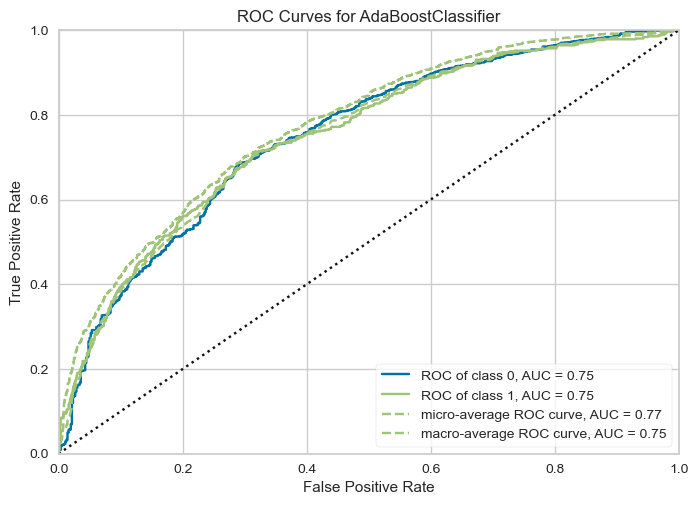

In [34]:
plot_model(best_model, plot="auc")

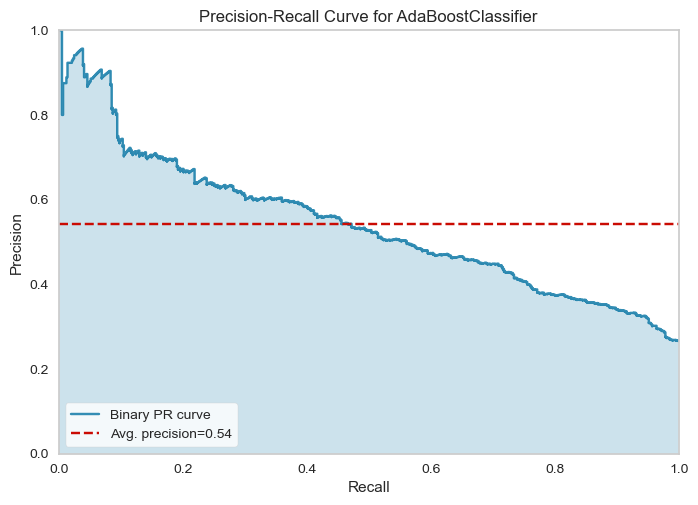

In [35]:
plot_model(best_model, plot="pr")

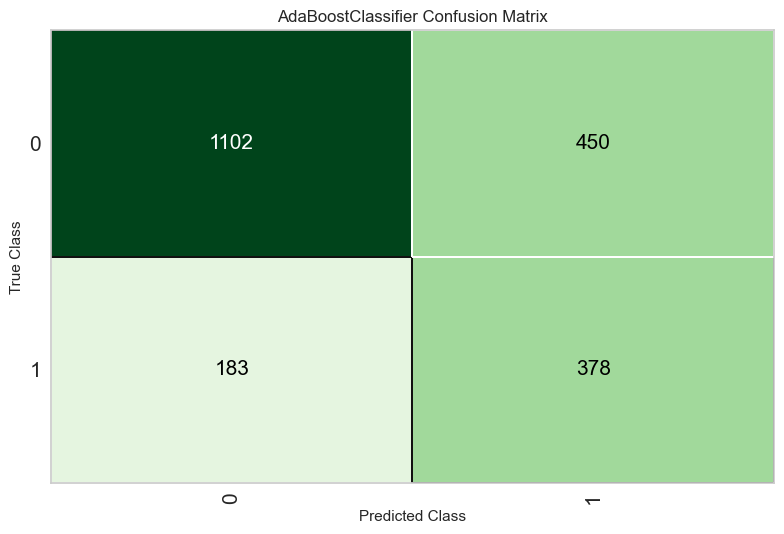

In [36]:
plot_model(best_model, plot="confusion_matrix")

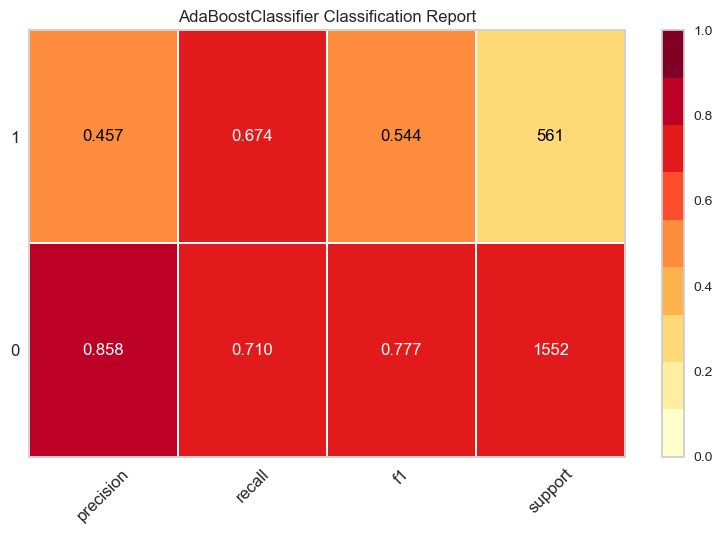

In [37]:
plot_model(best_model, plot="class_report")

In [38]:
predict_model(best_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.7004,0.7507,0.7004,0.7511,0.7151,0.3332,0.3472


In [39]:
final_model = finalize_model(best_model)

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt

def test_score_report(data_unseen, predict_unseen):
    le = LabelEncoder()
    # true labels from original Churn column
    y_true = le.fit_transform(data_unseen["Churn"])
    # predicted labels from PyCaret output
    y_pred = le.transform(predict_unseen["prediction_label"])
    # probabilities for ROC AUC
    y_proba = predict_unseen["prediction_score"]

    scores = {
        "Metric":   ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"],
        "Score": [
            accuracy_score(y_true, y_pred),
            precision_score(y_true, y_pred),
            recall_score(y_true, y_pred),
            f1_score(y_true, y_pred),
            roc_auc_score(y_true, y_proba),
        ],
    }
    return pd.DataFrame(scores)


def conf_mat(data_unseen, predict_unseen):
    le = LabelEncoder()
    y_true = le.fit_transform(data_unseen["Churn"])
    y_pred = le.transform(predict_unseen["prediction_label"])

    cm = confusion_matrix(y_true, y_pred)

    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = [0, 1]
    plt.xticks(tick_marks, ["No", "Yes"])
    plt.yticks(tick_marks, ["No", "Yes"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.7102,0.7999,0.7102,0.7827,0.7295,0.3511,0.3757


   Metric    Score
 Accuracy 0.710227
Precision 0.435714
   Recall 0.726190
       F1 0.544643
  ROC_AUC 0.411886


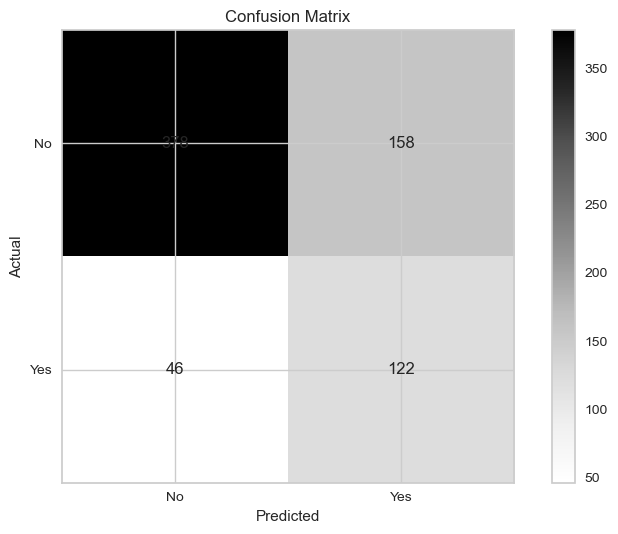

In [41]:
predict_unseen = predict_model(final_model, data=data_unseen)
score_unseen = test_score_report(data_unseen, predict_unseen)
print(score_unseen.to_string(index=False))
conf_mat(data_unseen, predict_unseen)

In [42]:
from pathlib import Path
from datetime import date

BASE_DIR = Path.home() / "Downloads"          # generic (no username hardcoded)
MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

model_path = MODELS_DIR / f"modelCCP_{date.today():%m-%d-%Y}"
save_model(final_model, str(model_path))


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None, include=['SeniorCitizen'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strate...
                                                                                          random_state=None,
                                                            